In [139]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [140]:
device = 'cuda'

## Here we simply predict the next step in the sequence. Each model is trained on 1/4 of the data

In [141]:
df = pd.read_csv('../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [142]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [143]:
def MSE(prediction_tensor, truth_tensor):
    return torch.sum(torch.pow(prediction_tensor-truth_tensor, 2))/truth_tensor.numel()

In [144]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [145]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [146]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [147]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length]) # Target is a single step

    return np.array(sequences), np.array(targets)


In [148]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[:int(n*0.8)]
val_df1 = first_piece[int(n*0.8):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device=device) # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device=device)  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1).to(device=device)  # (batch, output_dim)


In [149]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        out = self.fc(out[-1, :])  # Take the last 30 time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to(device)  # Use "cuda" if you have a GPU

# model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model2 = model2.to("cuda")  # Use "cuda" if you have a GPU

# model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model3 = model3.to("cuda")  # Use "cuda" if you have a GPU

criterion1 = nn.SmoothL1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)
# # scheduler = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=10, gamma=0.8)

# criterion2 = nn.SmoothL1Loss()
# optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
# criterion3 = nn.SmoothL1Loss()
# optimizer3 = optim.Adam(model3.parameters(), lr=0.0001)

In [150]:
train_seq_tensor1.shape

torch.Size([142, 12, 1])

In [151]:
val_seq_tensor1.shape

torch.Size([27, 12, 1])

In [152]:
first_piece.shape

(193, 1)

In [153]:
len(train_seq_tensor1)

142

In [154]:
train_seq_tensor1[0].shape

torch.Size([12, 1])

In [155]:
num_epochs = 100
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor1)):
        model1.train()
    
        optimizer1.zero_grad()
        y_pred = model1(train_seq_tensor1[i])
        loss = criterion1(y_pred, train_label_tensor1[i])
        # print(loss.item())
        loss.backward()
        optimizer1.step()
    
        train_losses.append(loss.item())

    # Validation
    model1.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor1)):
                y_val = model1(val_seq_tensor1[i])
                val_loss = criterion1(y_val, val_label_tensor1[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.05952826142311096, Val Loss: 0.1470155417919159
Epoch 10, Train Loss: 5.7671688409755006e-05, Val Loss: 0.0037322253920137882
Epoch 20, Train Loss: 3.284483796051063e-10, Val Loss: 0.0015763152623549104
Epoch 30, Train Loss: 0.002795934211462736, Val Loss: 0.0048777940683066845
Epoch 40, Train Loss: 0.0069730645045638084, Val Loss: 0.009841280989348888
Epoch 50, Train Loss: 0.005395061802119017, Val Loss: 0.005595221649855375
Epoch 60, Train Loss: 0.0038795515429228544, Val Loss: 0.0039808740839362144
Epoch 70, Train Loss: 0.001749310758896172, Val Loss: 0.0021449155174195766
Epoch 80, Train Loss: 0.0024279069621115923, Val Loss: 0.0027643954381346703
Epoch 90, Train Loss: 0.003604705212637782, Val Loss: 0.002456625457853079


### Check model 1 on dataset 1 performance

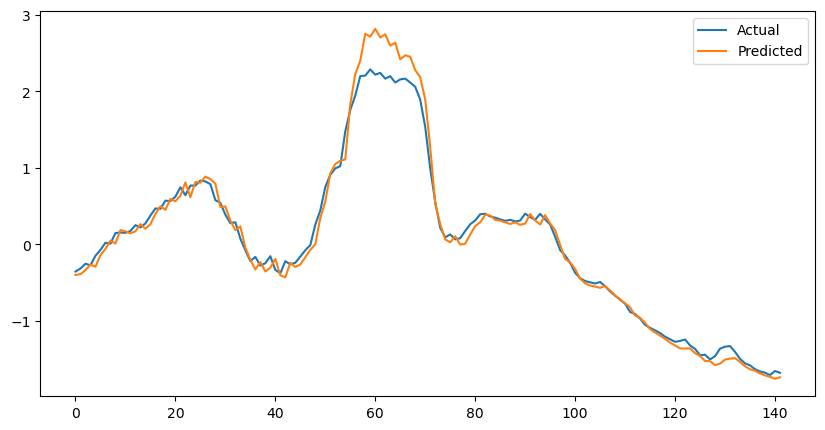

In [156]:
model1.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(train_seq_tensor1)):
        pred = model1(train_seq_tensor1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [157]:
train_label_tensor1.squeeze(1).shape

torch.Size([142])

In [158]:
torch.FloatTensor(y_pred).to(device=device).shape

torch.Size([142])

In [159]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), train_label_tensor1)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), train_label_tensor1)}')
criterion1(torch.FloatTensor(y_pred).to(device=device), train_label_tensor1).item()

MARE: 0.3298458755016327
MSE: 0.02542419545352459


/home/raman-pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([142, 1])) that is different to the input size (torch.Size([142])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


0.7917783260345459

In [160]:
normalized_test_1 = (first_piece[:] - first_piece.mean())/first_piece.std()
test_seq_1, test_labels_1 = create_sequences(normalized_test_1.values, 12)
test_tensor_seq_1 = torch.FloatTensor(test_seq_1).to(device=device)
test_tensor_labels_1 = torch.FloatTensor(test_labels_1).to(device=device)

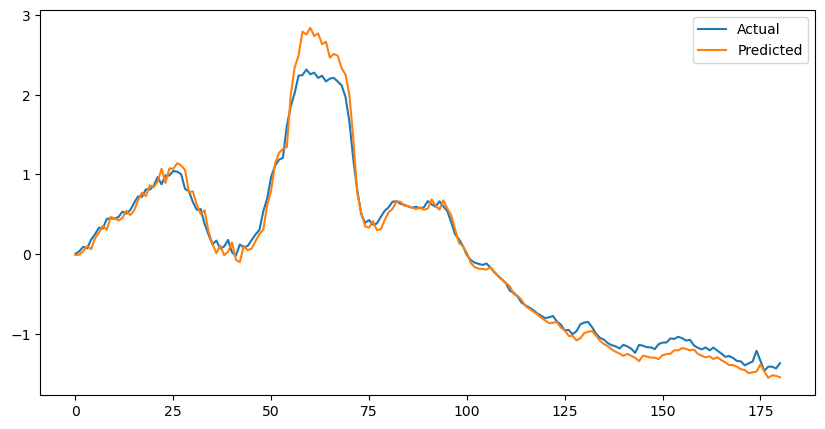

In [161]:
model1.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_1)):
        pred = model1(test_tensor_seq_1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [162]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
criterion1(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_1).item()

MARE: 0.34091100096702576
MSE: 0.022284062579274178


/home/raman-pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([181, 1])) that is different to the input size (torch.Size([181])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


0.8149666786193848

## Now let's test on datasets 2, 3, 4

### First create test set 2

In [163]:
normalized_test_2 = (second_piece[:] - second_piece.mean())/second_piece.std()
test_seq_2, test_labels_2 = create_sequences(normalized_test_2.values, 12)
test_tensor_seq_2 = torch.FloatTensor(test_seq_2).to(device=device)
test_tensor_labels_2 = torch.FloatTensor(test_labels_2).to(device=device)

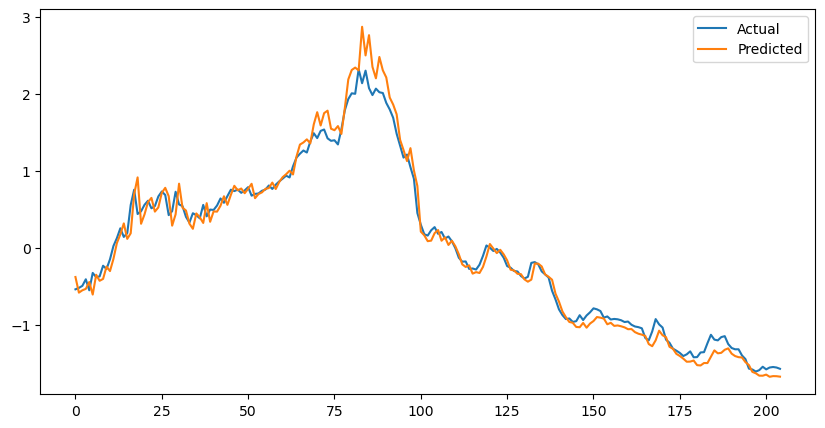

In [164]:
model1.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_2)):
        pred = model1(test_tensor_seq_2[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [165]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
criterion1(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_2)

MARE: 0.37842124700546265
MSE: 0.024238018319010735


/home/raman-pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([205, 1])) that is different to the input size (torch.Size([205])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


tensor(0.8113, device='cuda:0')

### Now dataset 3

In [166]:
normalized_test_3 = (third_piece[:] - third_piece.mean())/third_piece.std()
test_seq_3, test_labels_3 = create_sequences(normalized_test_3.values, 12)
test_tensor_seq_3 = torch.FloatTensor(test_seq_3).to(device='cuda')
test_tensor_labels_3 = torch.FloatTensor(test_labels_3).to(device='cuda')

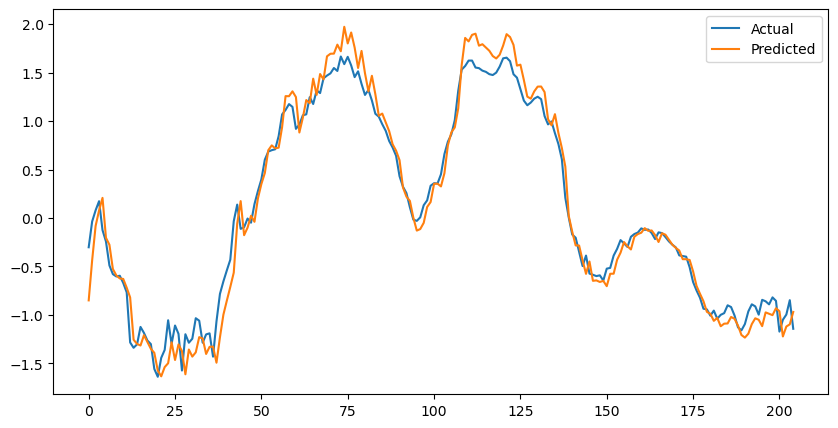

In [167]:
model1.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_3)):
        pred = model1(test_tensor_seq_3[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [168]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
criterion1(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_3)

MARE: 0.5664737820625305
MSE: 0.03157248720526695


tensor(0.7769, device='cuda:0')

### Finally Dataset 4

In [169]:
normalized_test_4 = (fourth_piece[:] - fourth_piece.mean())/fourth_piece.std()
test_seq_4, test_labels_4 = create_sequences(normalized_test_4.values, 12)
test_tensor_seq_4 = torch.FloatTensor(test_seq_4).to(device='cuda')
test_tensor_labels_4 = torch.FloatTensor(test_labels_4).to(device='cuda')

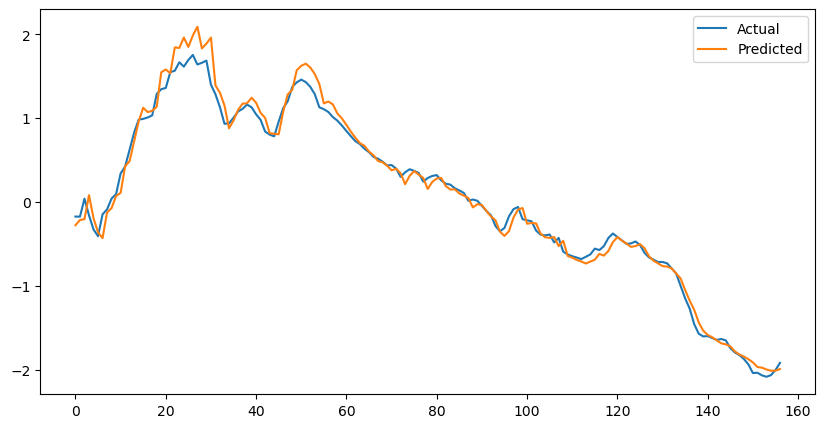

In [170]:
model1.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_4)):
        pred = model1(test_tensor_seq_4[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [171]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
criterion1(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_4)

MARE: 0.2549910545349121
MSE: 0.014861084520816803


/home/raman-pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([157, 1])) that is different to the input size (torch.Size([157])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


tensor(0.7680, device='cuda:0')

## Now we train Model 2 on Dataset 2

In [172]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.8)]
val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)
val_seq2, val_labels2 = create_sequences(val_df2.values, 12)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device=device) # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2).to(device=device)  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2).to(device=device)  # (batch, output_dim)

In [173]:
second_piece.shape

(217, 1)

In [174]:
train_seq_tensor2.shape

torch.Size([161, 12, 1])

In [175]:
val_seq_tensor2.shape

torch.Size([32, 12, 1])

In [176]:
model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to(device)  # Use "cuda" if you have a GPU
criterion2 = nn.SmoothL1Loss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)

In [177]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor2)):
        model2.train()
    
        optimizer2.zero_grad()
        y_pred = model2(train_seq_tensor2[i])
        loss = criterion2(y_pred, train_label_tensor2[i])
        # print(loss.item())
        loss.backward()
        optimizer2.step()
    
        train_losses.append(loss.item())

    # Validation
    model2.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor2)):
                y_val = model2(val_seq_tensor2[i])
                val_loss = criterion2(y_val, val_label_tensor2[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.9156124591827393, Val Loss: 1.5845024585723877
Epoch 10, Train Loss: 0.0012705015251412988, Val Loss: 0.12229716032743454
Epoch 20, Train Loss: 0.0010882638162001967, Val Loss: 0.0409763902425766
Epoch 30, Train Loss: 0.00614763842895627, Val Loss: 0.010280610993504524
Epoch 40, Train Loss: 0.008371503092348576, Val Loss: 0.0023589329794049263
Epoch 50, Train Loss: 0.005104505456984043, Val Loss: 0.003569587366655469
Epoch 60, Train Loss: 0.005747315939515829, Val Loss: 0.0026095409411937
Epoch 70, Train Loss: 0.0005439019296318293, Val Loss: 0.027647560462355614
Epoch 80, Train Loss: 0.002853961195796728, Val Loss: 0.01776157319545746
Epoch 90, Train Loss: 0.00021115396521054208, Val Loss: 0.04137513414025307


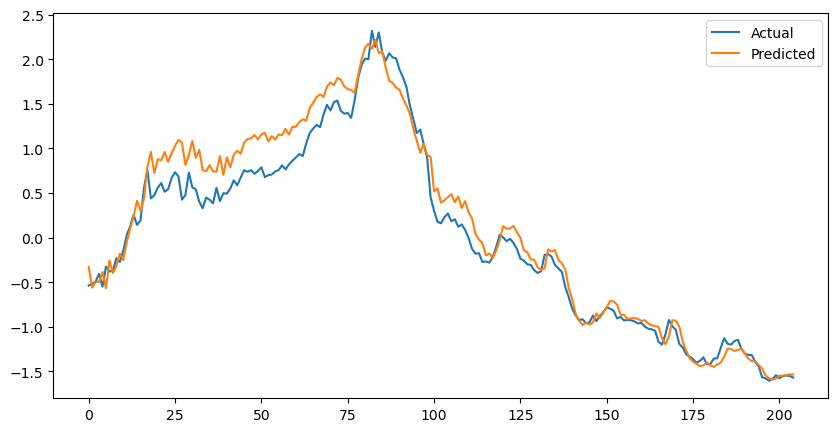

In [178]:
model2.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_2)):
        pred = model2(test_tensor_seq_2[i])
        y_pred.append(pred.item())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [179]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
criterion1(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_2).item()

MARE: 1.0676159858703613
MSE: 0.05145980417728424


0.8099440932273865

### Test on dataset 1

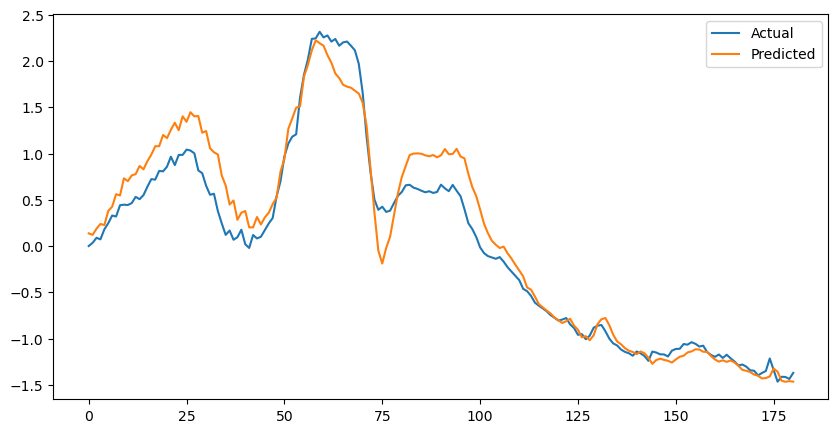

In [180]:
model2.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_1)):
        pred = model2(test_tensor_seq_1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [181]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_1).item()

MARE: 2.0999889373779297
MSE: 0.06353387981653214


0.8013479113578796

### Dataset 3

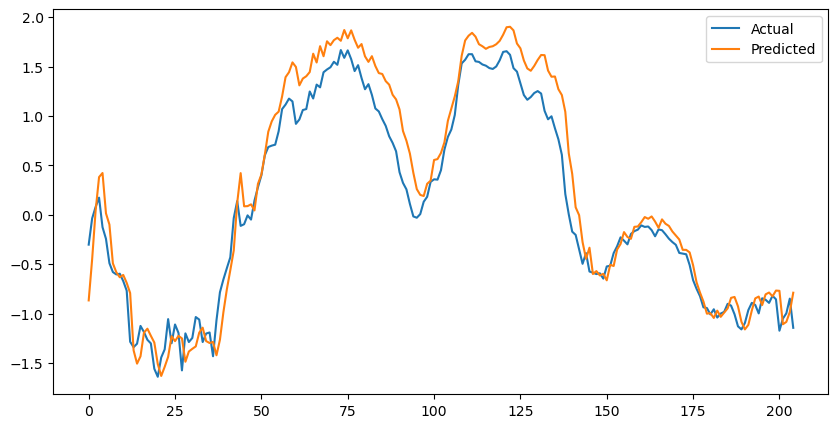

In [182]:
model2.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_3)):
        pred = model2(test_tensor_seq_3[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [183]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_3).item()

MARE: 1.4792500734329224
MSE: 0.07254031300544739


0.803425133228302

### Dataset 4

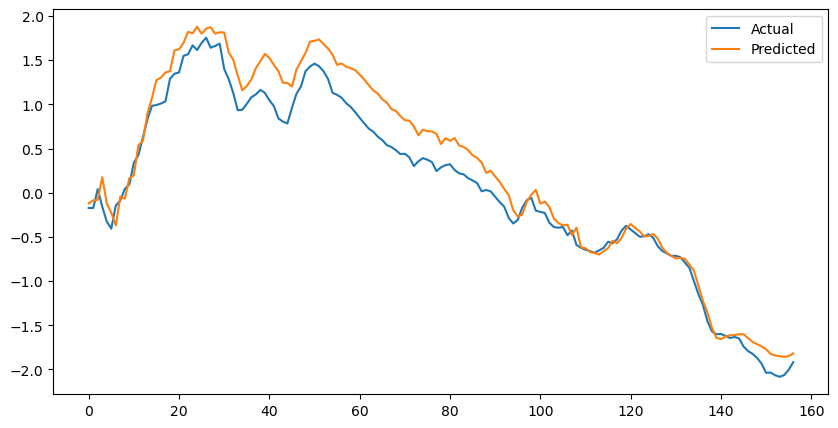

In [184]:
model2.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_4)):
        pred = model2(test_tensor_seq_4[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [185]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_4).item()

MARE: 0.7308648228645325
MSE: 0.06524472683668137


0.8089478611946106

### Now train Model 3 on dataset 3

In [186]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 =third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device='cuda') # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3).to(device='cuda')  # (batch, output_dim)

In [187]:
third_piece.shape

(217, 1)

In [188]:
train_seq_tensor3.shape

torch.Size([161, 12, 1])

In [189]:
val_seq_tensor3.shape

torch.Size([32, 12, 1])

In [190]:
model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to(device='cuda')
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-4)
criterion3 = nn.SmoothL1Loss()

In [191]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor3)):
        model3.train()
    
        optimizer3.zero_grad()
        y_pred = model3(train_seq_tensor3[i])
        loss = criterion3(y_pred, train_label_tensor3[i])
        # print(loss.item())
        loss.backward()
        optimizer3.step()
    
        train_losses.append(loss.item())

    # Validation
    model3.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor3)):
                y_val = model3(val_seq_tensor3[i])
                val_loss = criterion3(y_val, val_label_tensor3[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.042309366166591644, Val Loss: 0.7316529750823975
Epoch 10, Train Loss: 0.0014207964995875955, Val Loss: 0.09273194521665573
Epoch 20, Train Loss: 8.567891995880927e-07, Val Loss: 0.0674462541937828
Epoch 30, Train Loss: 7.752919918857515e-05, Val Loss: 0.101697638630867
Epoch 40, Train Loss: 0.00013395525456871837, Val Loss: 0.09291854500770569
Epoch 50, Train Loss: 0.000173713342519477, Val Loss: 0.06506592035293579
Epoch 60, Train Loss: 2.7287056582281366e-05, Val Loss: 0.06566726416349411
Epoch 70, Train Loss: 2.9091781470924616e-05, Val Loss: 0.06513698399066925
Epoch 80, Train Loss: 3.5128894069202943e-06, Val Loss: 0.05630352348089218
Epoch 90, Train Loss: 6.376991677825572e-06, Val Loss: 0.05325304716825485


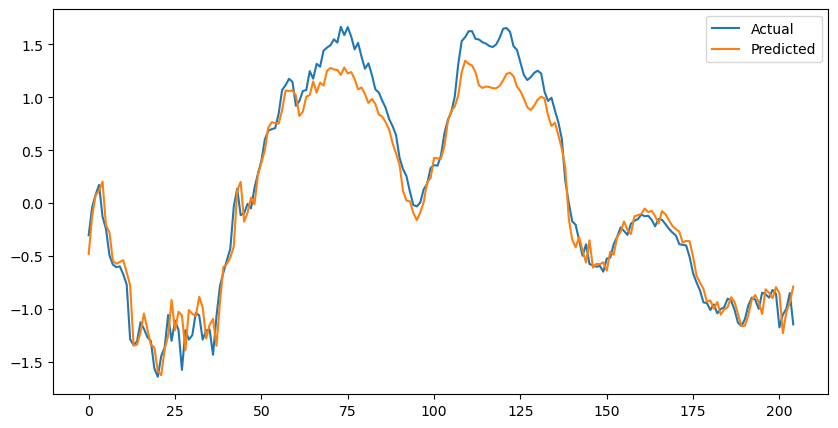

In [192]:
model3.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_3)):
        pred = model3(test_tensor_seq_3[i])
        y_pred.append(pred.item())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [193]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_3).item()

MARE: 0.6166431307792664
MSE: 0.03932242840528488


0.6616804599761963

### Test on dataset 1

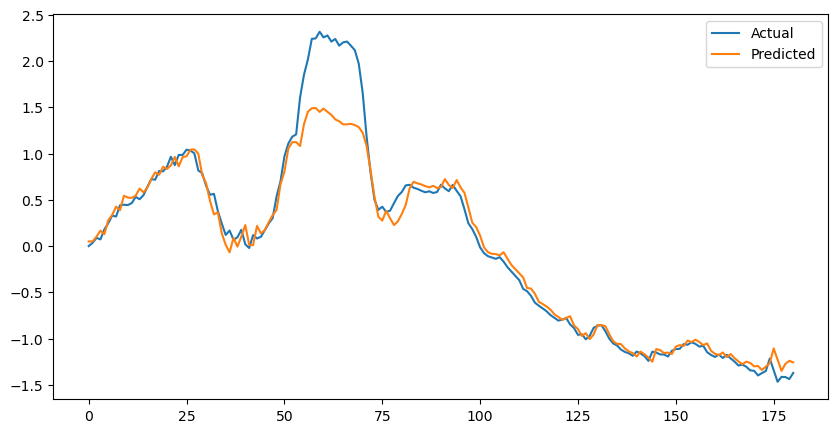

In [194]:
model3.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_1)):
        pred = model3(test_tensor_seq_1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [195]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_1).item()

MARE: 0.7731871604919434
MSE: 0.06062062084674835


0.6932699680328369

### Test on dataset 2

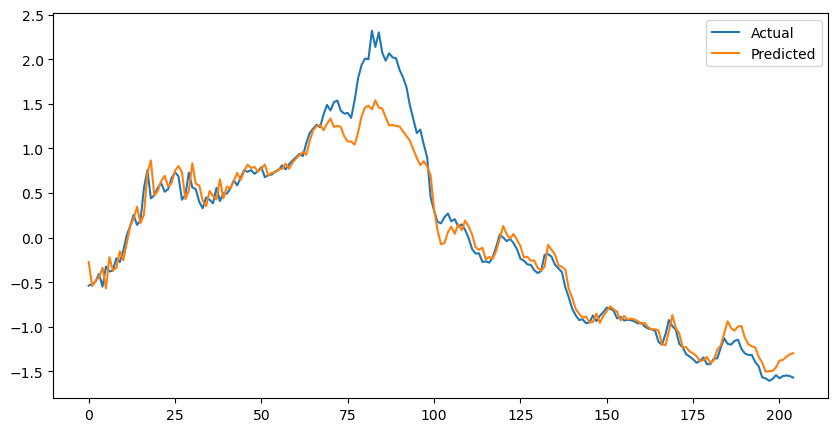

In [196]:
model3.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_2)):
        pred = model3(test_tensor_seq_2[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [197]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_2).item()

MARE: 0.6541433930397034
MSE: 0.0513991042971611


0.6961691379547119

### Test on dataset 4

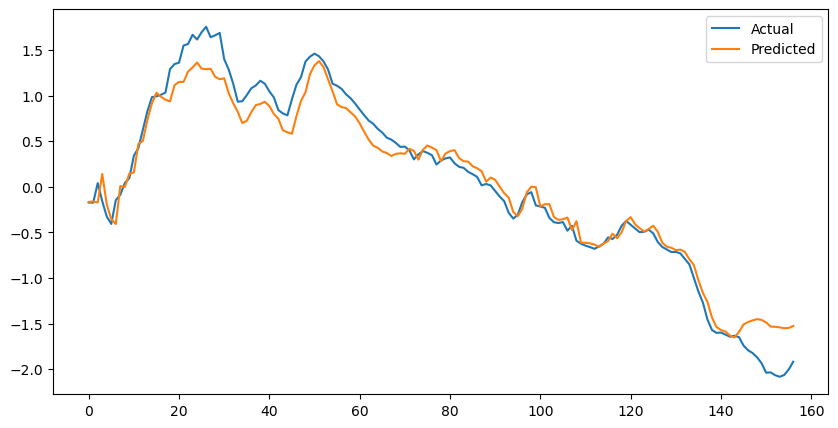

In [198]:
model3.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_4)):
        pred = model3(test_tensor_seq_4[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [199]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_4).item()

MARE: 0.38605403900146484
MSE: 0.04189632833003998


0.6618061065673828

## Train model 4 on dataset 4

In [200]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 =fourth_piece[0:int(n*0.8)]
val_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 12)
val_seq4, val_labels4 = create_sequences(val_df4.values, 12)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4).to(device='cuda') # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4).to(device='cuda')  # (batch, output_dim)

In [201]:
fourth_piece.shape

(169, 1)

In [202]:
train_seq_tensor4.shape

torch.Size([123, 12, 1])

In [203]:
val_seq_tensor4.shape

torch.Size([22, 12, 1])

In [204]:
model4 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion4 = nn.SmoothL1Loss()
optimizer4 = optim.Adam(model4.parameters(), lr=1e-4)
model4.to(device='cuda')

LSTMModel(
  (lstm): LSTM(1, 256, num_layers=3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [205]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor4)):
        model4.train()
    
        optimizer4.zero_grad()
        y_pred = model4(train_seq_tensor4[i])
        loss = criterion4(y_pred, train_label_tensor4[i])
        # print(loss.item())
        loss.backward()
        optimizer4.step()
    
        train_losses.append(loss.item())

    # Validation
    model4.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor4)):
                y_val = model4(val_seq_tensor4[i])
                val_loss = criterion4(y_val, val_label_tensor4[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.41422224044799805, Val Loss: 2.054703712463379
Epoch 10, Train Loss: 0.00020039081573486328, Val Loss: 0.5538523197174072
Epoch 20, Train Loss: 0.008449309505522251, Val Loss: 0.41825151443481445
Epoch 30, Train Loss: 0.002757813548669219, Val Loss: 0.30922847986221313
Epoch 40, Train Loss: 0.00025744098820723593, Val Loss: 0.22943980991840363
Epoch 50, Train Loss: 7.069944695103914e-05, Val Loss: 0.18884792923927307
Epoch 60, Train Loss: 0.00027189080719836056, Val Loss: 0.16766425967216492
Epoch 70, Train Loss: 0.001959261717274785, Val Loss: 0.19324465095996857
Epoch 80, Train Loss: 0.0024623945355415344, Val Loss: 0.23068493604660034
Epoch 90, Train Loss: 0.0053776404820382595, Val Loss: 0.18336419761180878


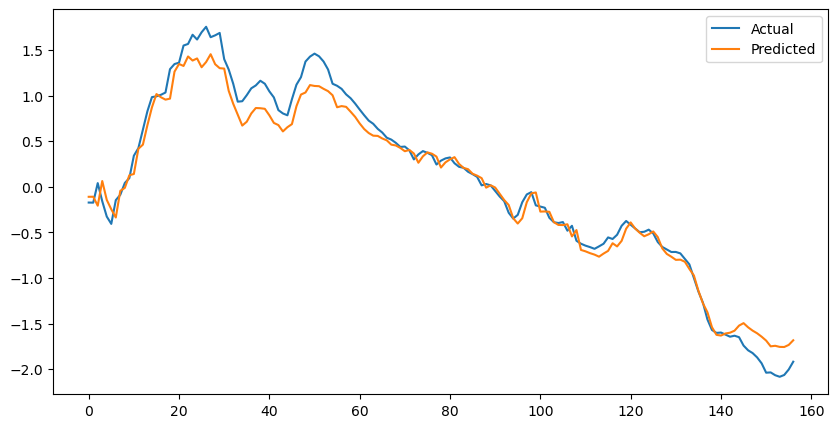

In [206]:
model4.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_4)):
        pred = model4(test_tensor_seq_4[i])
        y_pred.append(pred.item())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [207]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_4).item()

MARE: 0.2726738452911377
MSE: 0.027936413884162903


0.6835225820541382

### Test on dataset 1

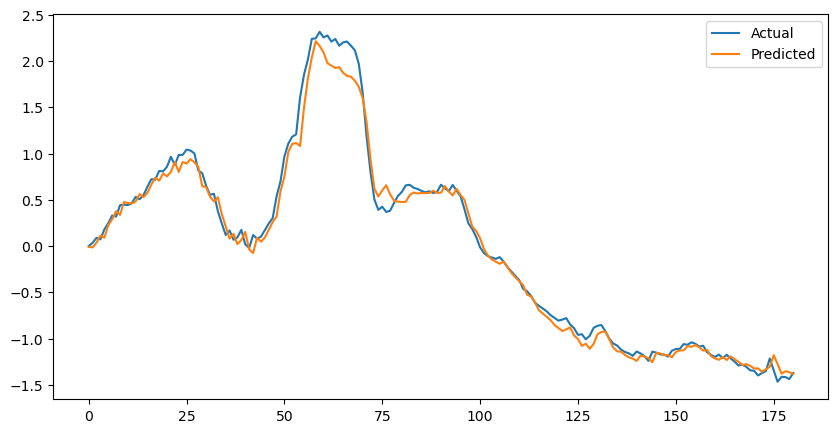

In [208]:
model4.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_1)):
        pred = model4(test_tensor_seq_1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [209]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_1).item()

MARE: 0.3148522973060608
MSE: 0.0139069315046072


0.741592288017273

### Test on dataset 2

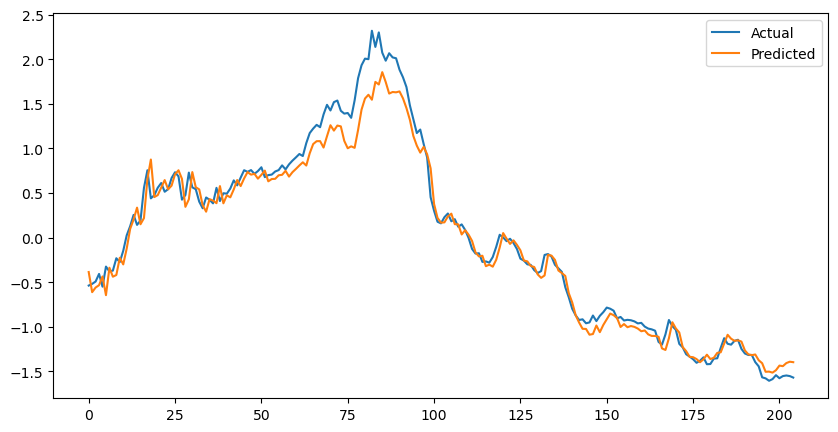

In [210]:
model4.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_2)):
        pred = model4(test_tensor_seq_2[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [211]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_2).item()

MARE: 0.3897951543331146
MSE: 0.030597267672419548


0.7189487218856812

### Test on dataset 3

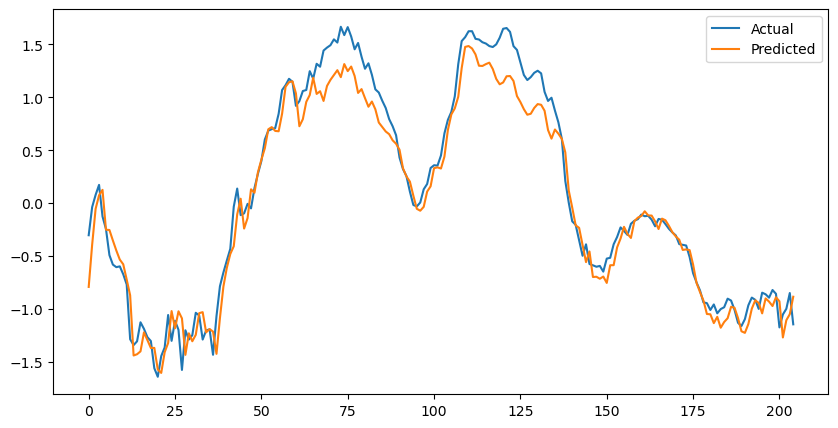

In [212]:
model4.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_3)):
        pred = model4(test_tensor_seq_3[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [213]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_3).item()

MARE: 0.6557338237762451
MSE: 0.04158543050289154


0.6794904470443726